In [1]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [1]:
!pip install -U scikit-image
!pip install -U ipympl

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)
Requirement already up-to-date: ipympl in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.6.3)


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
%matplotlib inline
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [4]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

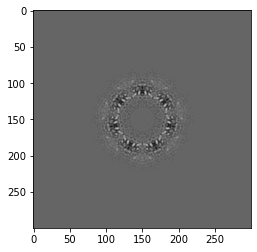

In [5]:
# Getting test T20S map
if not (os.path.exists('emd_6287.map.gz') or os.path.exists('emd_6287.map')):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    !gunzip 'emd_6287.map.gz'
map_path = 'emd_6287.map'

# https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
test_map = gemmi.read_ccp4_map(map_path)
test_map.setup()  # optional
test_numpy = np.array(test_map.grid, copy=False)

test_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))
test_slice = test_numpy[:, :, test_numpy.shape[2] // 2]
test_slice = np.expand_dims(test_slice, axis=-1)

plt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)

c = [test_slice.shape[0]//2, test_slice.shape[1]//2]
r = 256 // 2
img = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

In [6]:
def convert_to_tensor(img, sidelength):
    transform = Compose([
        ToPILImage(),
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = convert_to_tensor(img, sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

particle_slice = ImageFitting(img, 256)
dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)

siren_model = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
siren_model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
num_hidden_features = []
gpu_memory_features = []

In [8]:
# GPU Memory vs. Hidden Features

siren_model.cpu()
torch.cuda.empty_cache()

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for hidden_features in range(1, 256):
    num_hidden_features.append(hidden_features)
    
    # Assigning model to GPU
    siren_model = Siren(in_features=2, out_features=1, hidden_features=hidden_features, 
                      hidden_layers=3, outermost_linear=True)
    siren_model.cuda()
    siren_model(model_input)
    
    gpu_memory_features.append(torch.cuda.memory_allocated())
    
    # Freeing gpu
    siren_model.cpu()
    torch.cuda.empty_cache()

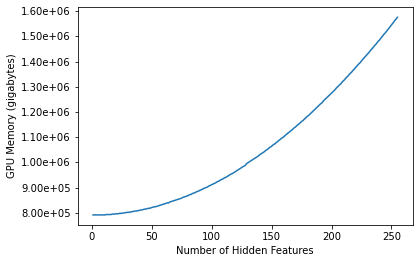

In [9]:
import matplotlib.ticker as mtick

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(num_hidden_features, gpu_memory_features)
plt.xlabel("Number of Hidden Features")
plt.ylabel("GPU Memory (gigabytes)")
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [9]:
gpu_memory_features_gb = [gpu_memory_feature * 9.3132257461548e-10 for gpu_memory_feature in gpu_memory_features]

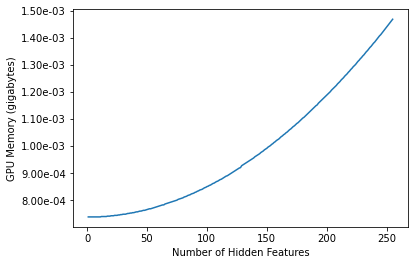

In [17]:
import matplotlib.ticker as mtick

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(num_hidden_features, gpu_memory_features_gb)
plt.xlabel("Number of Hidden Features")
plt.ylabel("GPU Memory (gigabytes)")
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [11]:
num_dims = []
gpu_memory_dims = []

In [12]:
# GPU Memory vs. Output Dimensionality

siren_model.cpu()
torch.cuda.empty_cache()

for output_dims in range(1, 256):
    num_dims.append(output_dims)

    # Setting up model
    siren_model = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)
    siren_model.cuda()

    # Preparing output size
    particle_slice = ImageFitting(img, output_dims)
    dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)

    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    
    siren_model(model_input)
    
    gpu_memory_dims.append(torch.cuda.memory_allocated())
    
    # Freeing gpu
    siren_model.cpu()
    torch.cuda.empty_cache()

In [13]:
gpu_memory_dims_gb = [gpu_memory_dim * 9.3132257461548e-10 for gpu_memory_dim in gpu_memory_dims]

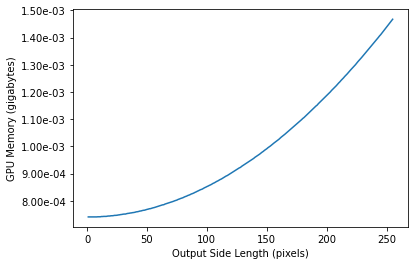

In [18]:
import matplotlib.ticker as mtick

fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel("Output Side Length (pixels)")
plt.ylabel("GPU Memory (gigabytes)")
ax.plot(num_dims, gpu_memory_dims_gb)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.show()

In [20]:
max_output_dims = 256
max_hidden_features = 256
gpu_memory = np.zeros(shape=(max_output_dims, max_hidden_features))

In [21]:
# GPU Memory vs. Output Dimensionality

siren_model.cpu()
torch.cuda.empty_cache()

for output_dims in range(1, max_output_dims):
    for hidden_features in range(1, max_hidden_features):

        # Setting up model
        siren_model = Siren(in_features=2, out_features=1, hidden_features=hidden_features, 
                          hidden_layers=3, outermost_linear=True)
        siren_model.cuda()

        # Preparing output size
        particle_slice = ImageFitting(img, output_dims)
        dataloader = DataLoader(particle_slice, batch_size=1, pin_memory=True, num_workers=0)

        model_input, ground_truth = next(iter(dataloader))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

        siren_model(model_input)

        gpu_memory[output_dims, hidden_features] = torch.cuda.memory_allocated()

        # Freeing gpu
        siren_model.cpu()
        torch.cuda.empty_cache()

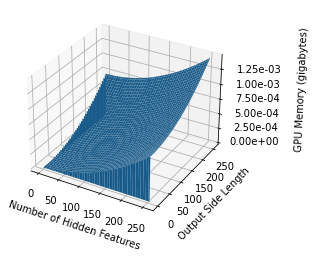

In [22]:
# Set up grid and test data
nx, ny = max_hidden_features, max_output_dims
x = range(nx)
y = range(ny)

gpu_memory_gb = gpu_memory * 9.3132257461548e-10

hf = plt.figure(1)
ax = hf.gca(projection='3d')
plt.xlabel("Number of Hidden Features")
plt.ylabel("Output Side Length")
ax.set_zlabel("GPU Memory (gigabytes)")
ax.zaxis.labelpad=30
ax.zaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.tick_params(axis='z', which='major', pad=15)

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, gpu_memory_gb)

plt.show()